In [2]:
!git clone https://<YOUR-KEY-HERE>/jpradov/ipeo_project.git
!pip install kornia imagecodecs==2023.9.18 wandb

fatal: destination path 'ipeo_project' already exists and is not an empty directory.


In [3]:
from google.colab import drive
import os
import sys
sys.path.append('/content/ipeo_project')
sys.path.append('/content/ipeo_project/utils')

drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingLR
from utils import data
import pandas as pd
from torch.utils.data import Subset, DataLoader
from torchvision import transforms
import config
from tqdm import tqdm
import kornia
import matplotlib.pyplot as plt
import numpy as np
from utils import evaluation

from models.msnet import MSNet
from torch.utils.data import DataLoader
from utils.data import create_dataloaders
from utils.train import run_training


In [5]:
#Should be cuda:0 in colab and cpu in local.
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
#DATA_PATH = config.PATH_TO_DATA
DATA_PATH = "/content/drive/MyDrive/ipeo_project/dataset/"

cuda:0


Downloading: "https://download.pytorch.org/models/resnet101-5d3b4d8f.pth" to /root/.cache/torch/hub/checkpoints/resnet101-5d3b4d8f.pth
100%|██████████| 170M/170M [00:02<00:00, 80.2MB/s]


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


 10%|█         | 10/100 [00:40<06:01,  4.02s/it]

Train Epoch: 1-0 batch_loss=3.10e-02 batch_acc=0.013


 20%|██        | 20/100 [00:49<02:54,  2.18s/it]

Train Epoch: 1-3 batch_loss=2.99e-02 batch_acc=0.014


 30%|███       | 30/100 [00:59<01:56,  1.67s/it]

Train Epoch: 1-6 batch_loss=2.88e-02 batch_acc=0.015


 40%|████      | 40/100 [01:11<01:28,  1.48s/it]

Train Epoch: 1-9 batch_loss=2.67e-02 batch_acc=0.015


 50%|█████     | 50/100 [01:27<01:15,  1.52s/it]

Train Epoch: 1-12 batch_loss=2.64e-02 batch_acc=0.016


 60%|██████    | 60/100 [01:39<00:56,  1.42s/it]

Train Epoch: 1-15 batch_loss=2.23e-02 batch_acc=0.018


 70%|███████   | 70/100 [01:54<00:43,  1.45s/it]

Train Epoch: 1-18 batch_loss=2.32e-02 batch_acc=0.018


 80%|████████  | 80/100 [02:07<00:27,  1.38s/it]

Train Epoch: 1-21 batch_loss=2.09e-02 batch_acc=0.019


 90%|█████████ | 90/100 [02:22<00:14,  1.44s/it]

Train Epoch: 1-24 batch_loss=2.17e-02 batch_acc=0.018


100%|██████████| 100/100 [02:34<00:00,  1.35s/it]

Train Epoch: 1-27 batch_loss=1.86e-02 batch_acc=0.023


110it [02:49,  1.41s/it]                         

Train Epoch: 1-30 batch_loss=1.97e-02 batch_acc=0.020


110it [02:54,  1.59s/it]
 10%|█         | 10/100 [00:03<00:34,  2.64it/s]

Train Epoch: 2-0 batch_loss=2.40e-02 batch_acc=0.017


 20%|██        | 20/100 [00:18<01:20,  1.00s/it]

Train Epoch: 2-3 batch_loss=2.01e-02 batch_acc=0.021


 30%|███       | 30/100 [00:27<01:08,  1.02it/s]

Train Epoch: 2-6 batch_loss=1.84e-02 batch_acc=0.021


 40%|████      | 40/100 [00:38<01:02,  1.04s/it]

Train Epoch: 2-9 batch_loss=1.58e-02 batch_acc=0.024


 50%|█████     | 50/100 [00:54<01:00,  1.21s/it]

Train Epoch: 2-12 batch_loss=1.76e-02 batch_acc=0.023


 60%|██████    | 60/100 [01:04<00:45,  1.15s/it]

Train Epoch: 2-15 batch_loss=2.07e-02 batch_acc=0.020


 70%|███████   | 70/100 [01:14<00:33,  1.11s/it]

Train Epoch: 2-18 batch_loss=1.97e-02 batch_acc=0.021


 80%|████████  | 80/100 [01:24<00:21,  1.06s/it]

Train Epoch: 2-21 batch_loss=1.97e-02 batch_acc=0.021


 90%|█████████ | 90/100 [01:34<00:10,  1.04s/it]

Train Epoch: 2-24 batch_loss=1.98e-02 batch_acc=0.021


100%|██████████| 100/100 [01:44<00:00,  1.02s/it]

Train Epoch: 2-27 batch_loss=1.90e-02 batch_acc=0.021


110it [01:53,  1.00it/s]                         

Train Epoch: 2-30 batch_loss=2.01e-02 batch_acc=0.021


110it [01:58,  1.08s/it]


ValueError: ignored

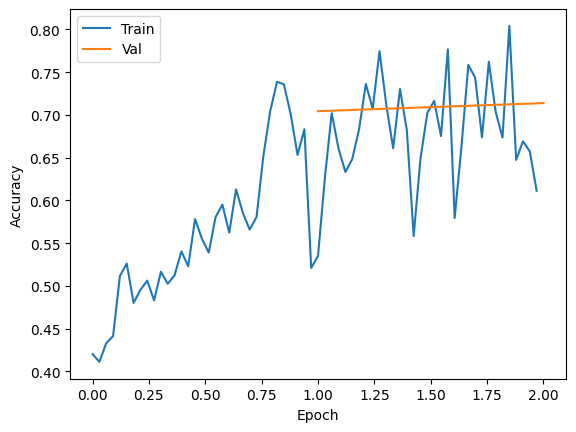

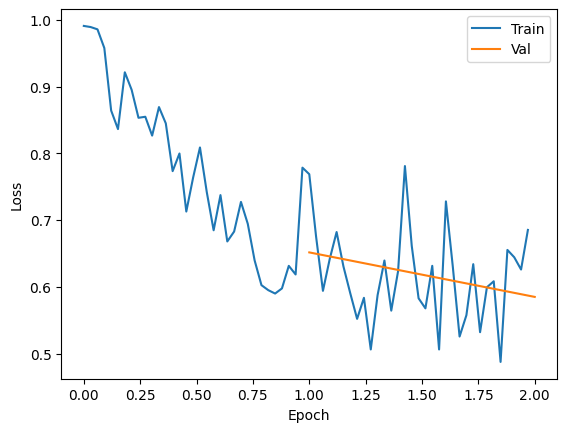

In [6]:
from models.deeplabv3plus import fetch_deeplabv3
%load_ext autoreload
%autoreload 2

max_epochs = 2

model = fetch_deeplabv3(output_stride=8, num_classes=2).to(device)
learning_rate = 1e-4
optimizer = optim.AdamW(model.parameters(),lr=learning_rate)
criterion = nn.CrossEntropyLoss()
results = run_training(experiment_name="test",model=model,num_epochs=max_epochs, bands=[0,1,2],lr=learning_rate,batch_size=32,device=device,data_dir=DATA_PATH)


In [7]:
from utils.evaluation import evaluate

train_dl, val_dl, test_dl = create_dataloaders(
        data_dir=DATA_PATH, batch_size=32, bands=[0,1,2], num_workers=0)

result = evaluate(model, device, test_dl, criterion)
print(result)

(0.5819586089980054, 0.7228642105583399, 0.4156781098640708, 0.6073307233356922, 0.5398220392280955, 0.522492400846956)
